In [ ]:
import pandas as pd
import numpy as np

Base de datos de Keagle [aquí](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?select=tmdb_5000_credits.csv)

# Demographic Filtering

In [ ]:
db1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie recomendation/tmdb_5000_credits.csv')
db2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie recomendation/tmdb_5000_movies.csv')

In [ ]:
db1.columns = ['id', 'tittle', 'cast', 'crew']
db1.columns

Index(['id', 'tittle', 'cast', 'crew'], dtype='object')

In [ ]:
db = db2.merge(db1, on='id')

In [ ]:
db.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'tittle', 'cast', 'crew'],
      dtype='object')

Calificación ponderada.
Formula >

v is the number of votes for the movie;

m is the minimum votes required to be listed in the chart;

R is the average rating of the movie;

C is the mean vote across the whole report


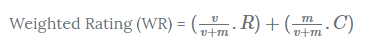


In [ ]:
c = db['vote_average'].mean()
m = db['vote_count'].quantile(0.9)

Filtramos aquellas peliculas que no tienen la suficiente cantidad de votos como para ser reecomendadas.

In [ ]:
recomended_movies = db.copy().loc[db['vote_count'] >= m]
print('Peliculas filtradas:', recomended_movies.shape[0])

Peliculas filtradas: 481


In [ ]:
# Creamos funcion de Calificación ponderada.
def weighted_rating(data_frame, c=c , m=m):
  v = data_frame['vote_count']
  R = data_frame['vote_average']

  return (v/(v+m) * R) + (m/(m+v) * c)

In [ ]:
recomended_movies['score'] = recomended_movies.apply(weighted_rating, axis=1)

In [ ]:
sort_movies = recomended_movies.sort_values('score', ascending=False)
sort_movies[['title', 'vote_count', 'vote_average', 'score']].head()

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239


Top pelicula mas recomendadas dentro de mi conjunto de dato.

In [ ]:
recomended_movies[['title', 'popularity']].head()

,title,popularity
0,Avatar,150.437577
1,Pirates of the Caribbean: At World's End,139.082615
2,Spectre,107.376788
3,The Dark Knight Rises,112.312950
4,John Carter,43.926995


# Content Based Filtering

Filtro deacuerdo a la cimilitud de la pelicula.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

In [ ]:
db_CBF = db.copy()
db_CBF.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'tittle', 'cast', 'crew'],
      dtype='object')

In [ ]:
# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

In [ ]:
# Replace NaN with an empty string
db_CBF['overview'] = db_CBF['overview'].fillna('')

In [ ]:
# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(db_CBF['overview'])

In [ ]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(db_CBF.index, index=db_CBF['title']).drop_duplicates()

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return db_CBF['title'].iloc[movie_indices]

In [ ]:
# Convierte cadenas de texto en estructura de datos si es que la base de datos la posee.
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
  db_CBF[feature] = db_CBF[feature].apply(literal_eval)

In [ ]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
  for i in x:
    if i['job'] == 'Director':
      return i['name']
  return np.nan

In [ ]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
  if isinstance(x, list):
    names = [i['name'] for i in x]
    #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
    if len(names) > 3:
      names = names[:3]
    return names

  #Return empty list in case of missing/malformed data
  return []

In [ ]:
# Define new director, cast, genres and keywords features that are in a suitable form.
db_CBF['director'] = db_CBF['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
  db_CBF[feature] = db_CBF[feature].apply(get_list)

In [ ]:
# Print the new features of the first 3 films
db_CBF[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [ ]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
  if isinstance(x, list):
    return [str.lower(i.replace(" ", "")) for i in x]
  else:
    #Check if director exists. If not, return empty string
    if isinstance(x, str):
      return str.lower(x.replace(" ", ""))
    else:
      return ''

In [ ]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
  db_CBF[feature] = db_CBF[feature].apply(clean_data)

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
db_CBF['soup'] = db_CBF.apply(create_soup, axis=1)

In [ ]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(db_CBF['soup'])

In [ ]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
# Reset index of our main DataFrame and construct reverse mapping as before
db_CBF = db_CBF.reset_index()
indices = pd.Series(db_CBF.index, index=db_CBF['title'])

In [ ]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object